## About

Sample notebook to fecth ECG, calculate HR abd HRV values

In [43]:
root_folder = "./../"
sys.path.insert(1, root_folder)
sys.path.insert(1, os.path.join(root_folder, 'tools/'))

#%%
import sys
import getopt

#Imports
import numpy as np
import multiprocessing # todo
from os.path import join as ospj
import sys
import pandas as pd
import seaborn as sns
from ieeg.auth import Session
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
from tools import get_iEEG_data
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import iirnotch, filtfilt, butter, lfilter, medfilt

import warnings
warnings.filterwarnings("ignore")

import biosppy
from biosppy.signals import ecg
import pyhrv
import pyhrv.tools as tools
from pyhrv.hrv import hrv
import neurokit2 as nk
import heartpy as hp
import pyhrv.time_domain as td 
import pyhrv.frequency_domain as fd

from datetime import datetime, date, timedelta
import importlib

from scipy import signal
from scipy.signal import butter, lfilter, freqz, filtfilt, find_peaks, medfilt, ellip
from scipy.signal import savgol_filter, hilbert
import sys
import os
import json



from helpers import *


    

In [27]:
def remove_std(signal, std_mul=1.5):
    std_rem = signal.copy()
    mean = np.mean(std_rem)
    std = np.std(std_rem)
    std_rem[(std_rem<(mean+std_mul*std)) & (std_rem>(mean-std_mul*std))]=mean
    return std_rem

In [16]:
username = 'jalpanchal'
pwd_bin_path = "/users/jalp/tools/jal_ieeglogin.bin"
with open(pwd_bin_path, "r") as f:
    s = Session(username, f.read())   
    
#import login credentials
from cryptography.fernet import Fernet
import os
 
cred_filename = '/users/jalp/ieeg_credentials/CredFile.ini'
key_file = '/users/jalp/ieeg_credentials/key.key'
 
key = ''
 
with open(key_file,'r') as key_in:
    key = key_in.read().encode()
  
f = Fernet(key)
with open(cred_filename,'r') as cred_in:
    lines = cred_in.readlines()
    config = {}
    for line in lines:
        tuples = line.rstrip('\n').split('=',1)
        if tuples[0] in ('Username','Password'):
            config[tuples[0]] = tuples[1]
 
    password = f.decrypt(config['Password'].encode()).decode()
    user = config['Username']

In [13]:
subject_name = "HUP_173"
start_flag=90129.85
end_flag=90129.85+300

In [40]:

#Configuring getting  ieeg data
portal_name = "HUP173_phaseII"
print("Getting data for %s" %(subject_name))

print("Getting data for %s from IEEG" %(portal_name))

with open(pwd_bin_path, "r") as f:
    s = Session(username, f.read())
ds = s.open_dataset(portal_name)

if start_flag!='0':
    start_time_sec = int(start_flag)
else:
    start_time_sec = 0

if end_flag!='0':
    end_time_sec = int(end_flag)
else:
    end_time_sec = (ds.end_time-ds.start_time)/1e6
print("time stamps retrived from IEEG")
print("Getting data for %d to %d" %(start_time_sec, end_time_sec))

data_pull_min=5
# ecg_channels = [metadata.loc[subject_name]['ECG Electrode']]
ecg_channels = ['EKG01']

clip_duration_sec =  end_time_sec - start_time_sec
clip_duration_min = clip_duration_sec / 60

# how many data_pull_min minute data pulls are there?
n_iter = int(np.ceil(clip_duration_min / data_pull_min))


Getting data for HUP_173
Getting data for HUP173_phaseII from IEEG
time stamps retrived from IEEG
Getting data for 90129 to 90429


In [41]:
hr_win = pd.DataFrame()
temp_std= pd.DataFrame()
temp_peaks = pd.DataFrame()
temp_ecg = pd.DataFrame()
for i in tqdm(range(n_iter)):

    start_usec = start_time_sec * 1e6 + i * (5 * 60 * 1e6)
    if i == n_iter - 1:
        end_usec = end_time_sec * 1e6
    else:
        end_usec = start_usec + (5 * 60 * 1e6)
    data, fs = get_iEEG_data(username, pwd_bin_path, portal_name, start_usec, end_usec, select_electrodes=ecg_channels)

    time = np.linspace(start_usec, end_usec, len(data), endpoint=False)
    data.index = pd.to_datetime(time, unit='us')

    # format resulting data into pandas DataFrame
    signal_filt = pd.DataFrame(columns=ecg_channels, index=data.index)

    ecg_mul = -1

    hr_df = pd.DataFrame()
    for n,c in enumerate(ecg_channels):
        #remove baseline wander
        temp_ = hp.remove_baseline_wander(data.iloc[:,n]*ecg_mul, fs)


        #bandpas filter
        order = int(0.3 * fs)
        signal_filt[c], _, _ = biosppy.tools.filter_signal(signal=temp_,ftype='FIR',band='bandpass',order=order,frequency=[3,25],sampling_rate=fs)


        # work on 5s samples
        # ll = []
        # temp2_= pd.DataFrame()
        for i in range(int(len(signal_filt)/int(5*fs))):

            win_data = signal_filt[i*5*int(fs):(i+1)*5*int(fs)][c]

            #remove noise data > 1.5 std

            std_rem = remove_std(win_data, 1.5)
            temp_std = temp_std.append(pd.DataFrame(std_rem))

        try :
        
            out = ecg.ecg(signal=temp_std[c], sampling_rate=fs, show=False)
            ecg_filtered = out[1]
            rpeaks = out[2]
            heart_rate_ts = out[-2]
            heart_rate = out[-1]
            idx = (heart_rate_ts*fs).astype(int)

            

            temp_ = pd.DataFrame(data={c : heart_rate}, index=temp_std.index[idx])
            hr_df = hr_df.append(temp_)

            temp2_ = pd.DataFrame(data={c : ecg_filtered[idx]}, index=temp_std.index[idx])
            temp_peaks = temp_peaks.append(temp2_)

            temp3_ = pd.DataFrame(data={c : ecg_filtered}, index=temp_std.index)
            temp_ecg = temp_ecg.append(temp3_)
        except:
                continue 
    
    #shift time to real time
    # hr_df.index = pd.to_datetime(hr_df.index).tz_localize(tz)


    # resample to 6Hz
    hr_rs = hr_df.resample("10s").mean()   

    #take the min in each 10s window
    hr_min = hr_rs.min(axis=1)

    hr_win = hr_win.append(pd.DataFrame(hr_min))

# %%
#smoothen
hr_sm = pd.DataFrame({'heartRate' : savgol_filter(hr_win[0].dropna(), 9,4)}, index=hr_win.dropna().index)
hr_sm['heartRate'] = hr_sm['heartRate'].apply(lambda x : round(x,1))


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


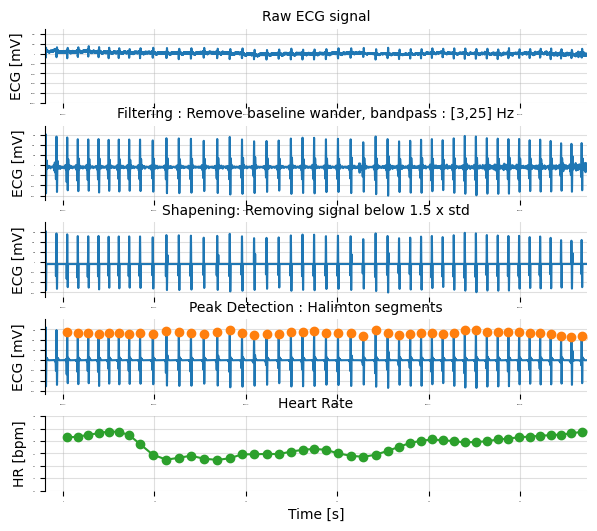

In [47]:

ch = ['EKG01']
rw = 5

# Apply the default theme
# sns.set_style('whitegrid')
plt.rcParams.update({"font.size":1})
fig, ax = plt.subplots(rw,1, figsize = [7,6], sharex=True)
xlim = [data.index[0],data.index[7600]]

axi = plt.subplot(rw,1,1)
axi.plot(data.index, data[ch])
axi.grid(alpha=0.4)
axi.set_ylim([-10000,5000])
axi.set_xlim (xlim)
axi.set_ylabel("ECG [mV]", fontsize=10)
axi.set_title("Raw ECG signal", fontsize=10)
sns.despine(bottom=True, ax=axi)

axi = plt.subplot(rw,1,2)
axi.plot(data.index, signal_filt[ch])
axi.grid(alpha=0.4)
# axi.set_ylim([-500,500])
axi.set_xlim (xlim)
axi.set_ylabel("ECG [mV]", fontsize=10)
axi.set_title("Filtering : Remove baseline wander, bandpass : [3,25] Hz", fontsize=10)
sns.despine(bottom=True, ax=axi)

axi = plt.subplot(rw,1,3)
axi.plot(data.index, temp_std[ch])
axi.grid(alpha=0.4)
# axi.set_ylim([-500,500])
axi.set_xlim (xlim)
axi.set_ylabel("ECG [mV]", fontsize=10)
axi.set_title("Shapening: Removing signal below 1.5 x std", fontsize=10)
sns.despine(bottom=True, ax=axi)

axi = plt.subplot(rw,1,4)
axi.plot(temp_ecg.index, temp_ecg[ch])
axi.plot(temp_peaks.index, temp_peaks[ch], 'o')
axi.grid(alpha=0.4)
# axi.set_ylim([-500,500])
axi.set_ylabel("ECG [mV]", fontsize=10)
axi.set_title("Peak Detection : Halimton segments", fontsize=10)
axi.set_xlim (xlim)
sns.despine(bottom=True, ax=axi)

axi = plt.subplot(rw,1,5)
axi.plot(hr_df[ch].dropna(), 'o-', color='C2')
axi.grid(alpha=0.4)
axi.set_ylim([60,120])
axi.set_ylabel("HR [bpm]", fontsize=10)
axi.set_title("Heart Rate", fontsize=10)
axi.set_xlim (xlim)
sns.despine(bottom=True, ax=axi)


xformatter = mdates.DateFormatter('%S')
axi.xaxis.set_major_formatter(xformatter)
axi.set_xticklabels([5,10,15,20,25,30])
axi.set_xlabel("Time [s]", fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
plt.show()